In [2]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

In [3]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

#add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

  01 X01_WT_DAI0 02 X02_13_DAI0 03 X03_17_DAI0 04 X06_efrfls2_DAI0
1       4.325279       4.240958       4.240958            4.437253
2       4.094830       4.325279       4.174012            4.437253
3       4.350103       4.208774       4.136223            4.509804
4       4.350103       4.208774       4.325279            4.541988
5             NA             NA             NA                  NA
6             NA             NA             NA                  NA
  05 X07_WT_DAI3 06 X08_13_DAI3 07 X09_17_DAI3 08 X12_efrfls2_DAI3   Group
1       6.136223       6.793800       7.456558            6.793800 Trial01
2       6.417050       6.793800       7.350103            6.793800 Trial01
3       5.997920       6.939928       7.350103            6.997920 Trial01
4       6.240958       6.696890       7.417050            6.872982 Trial01
5       5.557228       6.696890       7.094830            7.325279 Trial01
6       5.571952       7.174012       6.997920            6.939928 Trial01
# A ti

# A tibble: 6 × 3
  Treatment      Trial   VALUE
  <chr>          <chr>   <dbl>
1 01 X01_WT_DAI0 Trial01  4.33
2 01 X01_WT_DAI0 Trial01  4.09
3 01 X01_WT_DAI0 Trial01  4.35
4 01 X01_WT_DAI0 Trial01  4.35
5 02 X02_13_DAI0 Trial01  4.24
6 02 X02_13_DAI0 Trial01  4.33


[1]  2 11

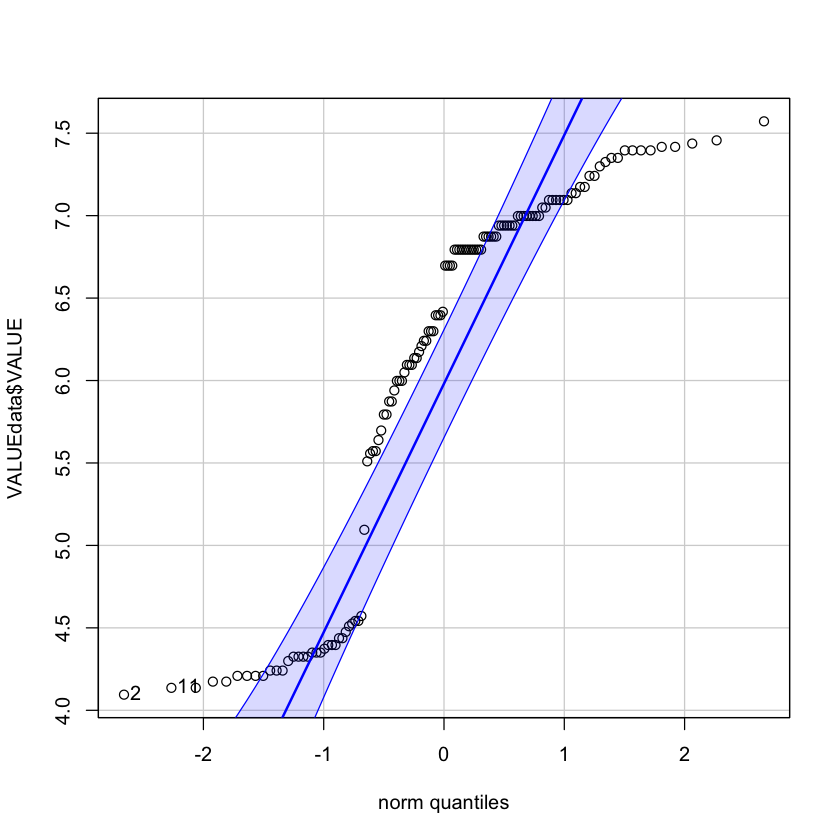

In [4]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

     AIC      BIC   logLik deviance df.resid 
    50.2     78.8    -15.1     30.2      118 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.01075 -0.48593 -0.00014  0.58153  2.26089 

Random effects:
 Groups   Name        Variance Std.Dev.
 Trial    (Intercept) 0.00000  0.0000  
 Residual             0.07415  0.2723  
Number of obs: 128, groups:  Trial, 2

Fixed effects:
                              Estimate Std. Error        df t value Pr(>|t|)
(Intercept)                    4.37964    0.09628 128.00000  45.490   <2e-16
Treatment02 X02_13_DAI0       -0.03673    0.13616 128.00000  -0.270    0.788
Treatment03 X03_17_DAI0       -0.14583    0.13616 128.00000  -1.071    0.286
Treatment04 X06_efrfls2_DAI0  -0.02023    0.13616 128.00000  -0.149    0.882
Treatment05 X07_WT_DAI3        1.53505    0.11117 128.000

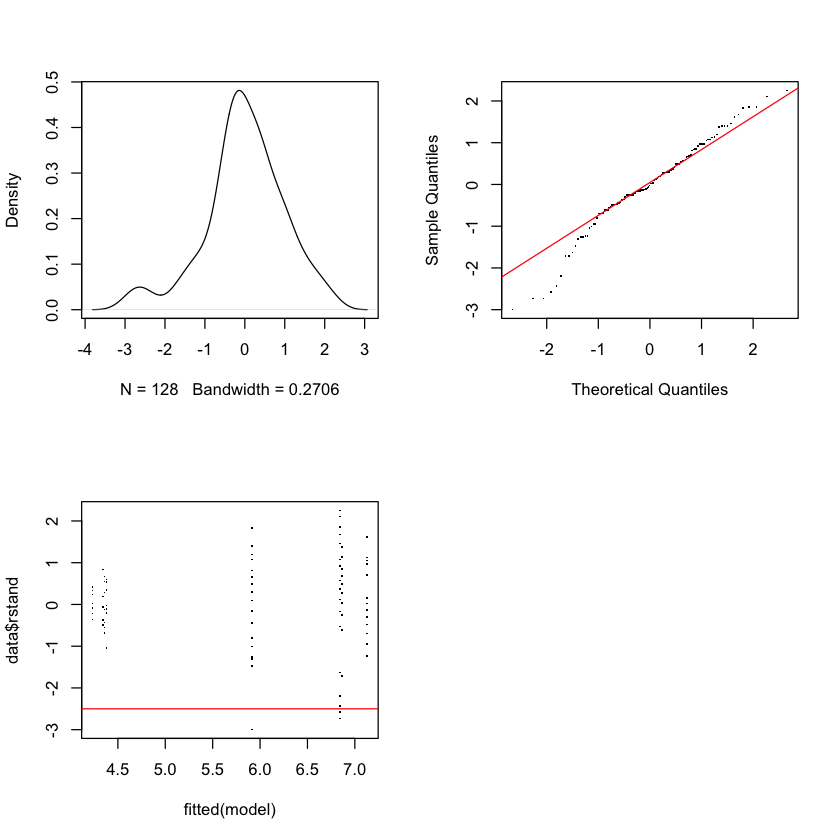

In [5]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [6]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq         Mean Sq          NumDF       DenDF        F value     
 Min.   :153.9   Min.   :21.99   Min.   :7   Min.   :128   Min.   :296.5  
 1st Qu.:153.9   1st Qu.:21.99   1st Qu.:7   1st Qu.:128   1st Qu.:296.5  
 Median :153.9   Median :21.99   Median :7   Median :128   Median :296.5  
 Mean   :153.9   Mean   :21.99   Mean   :7   Mean   :128   Mean   :296.5  
 3rd Qu.:153.9   3rd Qu.:21.99   3rd Qu.:7   3rd Qu.:128   3rd Qu.:296.5  
 Max.   :153.9   Max.   :21.99   Max.   :7   Max.   :128   Max.   :296.5  
     Pr(>F)         
 Min.   :7.232e-76  
 1st Qu.:7.232e-76  
 Median :7.232e-76  
 Mean   :7.232e-76  
 3rd Qu.:7.232e-76  
 Max.   :7.232e-76  

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                                               Estimate Std. Error z value
02 X02_13_DAI0 - 01 X01_WT_DAI0 == 0     